In [2]:
import tensorflow
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, SpatialDropout1D, LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

### Set hyperparameters

In [8]:
# output directory
output_dir = 'model_output/stackedLSTM'

# training
epochs = 4
batch_size = 128

# vector space embedding
n_dim = 64
n_unique_words = 10000
max_review_length = 200
pad_type = trunc_type = 'pre'
drop_embed = 0.2

# convolutional layer
n_lstm_1 = 256
n_lstm_2 = 64
drop_lstm = 0.2

# dense layer (usually not needed for RNN)
# n_dense = 256
# dropout = 0.2

### Load data

In [9]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words)                                                       

### Preprocess data

In [10]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type,
                        truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type,
                        truncating=trunc_type, value=0)

### Design neural network

In [11]:
model = Sequential()

# first hidden layer
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
model.add(SpatialDropout1D(drop_embed))

# first LSTM layer
model.add(Bidirectional(LSTM(n_lstm_1, dropout=drop_lstm, return_sequences=True)))

# second LSTM layer
model.add(Bidirectional(LSTM(n_lstm_2, dropout=drop_lstm)))

# output layer
model.add(Dense(1, activation='sigmoid'))

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 64)           640000    
                                                                 
 spatial_dropout1d_1 (Spati  (None, 200, 64)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional (Bidirection  (None, 200, 512)          657408    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               295424    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                      

### Configure model

In [13]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [14]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

### Train

In [15]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1,
          validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Epoch 1/4


2024-03-04 09:55:17.906050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


196/196 [==============================] - 45s 198ms/step - loss: 0.6352 - accuracy: 0.6423 - val_loss: 0.5162 - val_accuracy: 0.7512
Epoch 2/4


/Users/jaejin/mambaforge/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


196/196 [==============================] - 35s 180ms/step - loss: 0.4745 - accuracy: 0.7813 - val_loss: 0.5540 - val_accuracy: 0.7018
Epoch 3/4
196/196 [==============================] - 34s 175ms/step - loss: 0.3692 - accuracy: 0.8441 - val_loss: 0.3843 - val_accuracy: 0.8363
Epoch 4/4
196/196 [==============================] - 33s 170ms/step - loss: 0.2612 - accuracy: 0.8965 - val_loss: 0.3476 - val_accuracy: 0.8514


### Evaluate

In [16]:
model.load_weights(output_dir+"/weights.04.hdf5")

In [17]:
y_hat = model.predict(x_valid)

782/782 [==============================] - 25s 31ms/step


In [18]:
y_hat.shape

(25000, 1)

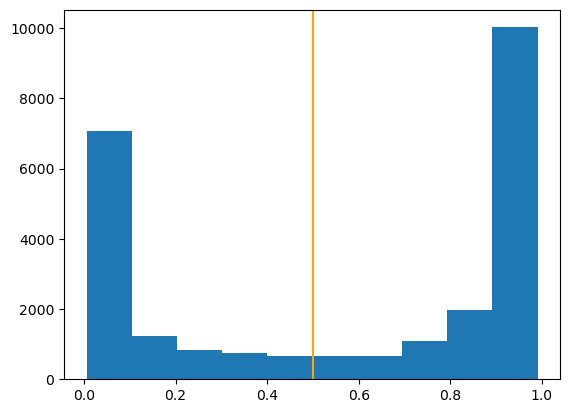

In [19]:
plt.hist(y_hat)
# plt.axvline(x=0.5, color='orange')
_ = plt.axvline(x=0.5, color='orange')

In [20]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat) * 100.0)

'93.78'